In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import sklearn
import optuna

In [32]:
def clean(ticker):
    ydf = yf.download(ticker, interval="1d")
    #ydf.to_csv(f'y{ticker}.csv')
    ydf.to_csv(f'test.csv')

    # btc = pd.read_csv(f'y{ticker}.csv')
    btc = pd.read_csv(f'test.csv')
    btc = btc.drop([0,1])
    btc['Date'] = pd.to_datetime(btc['Price']).dt.date
    # btc['Date'] = pd.to_datetime(btc['Price']).dt.floor('T')
    btc= btc.set_index('Date')
    btc = btc.drop(['Price'], axis = 1)
    btc = btc.reset_index()
    #btc['Ticker'] = ticker
    return btc

In [33]:
btc = clean('BTC-USD')
btc[btc.columns[1:]] = btc[btc.columns[1:]].astype(float)

btc

[*********************100%***********************]  1 of 1 completed


,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,2.105680e+07
1,2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,3.448320e+07
2,2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,3.791970e+07
3,2014-09-20,408.903992,408.903992,423.295990,389.882996,394.673004,3.686360e+07
4,2014-09-21,398.821014,398.821014,412.425995,393.181000,408.084991,2.658010e+07
...,...,...,...,...,...,...,...
3714,2024-11-17,89845.851562,89845.851562,91433.039062,88741.664062,90558.460938,4.635016e+10
3715,2024-11-18,90542.640625,90542.640625,92596.789062,89393.593750,89843.718750,7.553578e+10
3716,2024-11-19,92343.789062,92343.789062,94002.867188,90426.984375,90536.812500,7.452105e+10
3717,2024-11-20,94339.492188,94339.492188,94902.023438,91619.500000,92341.890625,7.173096e+10


In [34]:

btc['ret'] = btc['Adj Close'].pct_change()
btc['logret'] = np.log1p(btc['ret'])
btc['Gain'] = btc['logret'].apply(lambda x: x if x > 0 else 0)
btc['Loss'] = btc['logret'].apply(lambda x: -x if x < 0 else 0)

windows = [7, 15, 30, 60, 120, 180]

for i in windows:
    #rolling volatilities
    btc[f'vol_{i}'] = btc['logret'].rolling(window=i).std()

    #relative strength index
    btc[f'RSI_{i}'] = 100 - (100 / (1 + (btc['Gain'].rolling(window=i).mean() / btc['Loss'].rolling(window=i).mean())))

    # momentum score
    btc[f'mom_{i}'] = (1/i) * btc['logret'].rolling(i,i).sum().reset_index(drop=True)

    #exponential moving average
    btc[f'ewma_{i}'] = btc['logret'].ewm(span=i, min_periods=i).mean()

btc = btc.dropna().reset_index(drop=True)
btc['target'] = (btc['logret'].shift(-1) > 0).astype(int)
btc


,Date,Adj Close,Close,High,Low,Open,Volume,ret,logret,Gain,...,ewma_60,vol_120,RSI_120,mom_120,ewma_120,vol_180,RSI_180,mom_180,ewma_180,target
0,2015-03-16,290.592987,290.592987,294.112000,285.684998,285.684998,2.151610e+07,0.014665,0.014559,0.014559,...,0.003347,0.046246,46.023427,-0.002406,0.000585,0.043956,45.790611,-0.002519,-0.000496,0
1,2015-03-17,285.505005,285.505005,292.364990,284.373993,290.595001,2.149720e+07,-0.017509,-0.017664,0.000000,...,0.002656,0.046267,45.815970,-0.002543,0.000268,0.043637,46.280156,-0.002203,-0.000715,0
2,2015-03-18,256.299011,256.299011,285.335999,249.869995,285.066986,5.700800e+07,-0.102296,-0.107915,0.000000,...,-0.000978,0.047183,44.882128,-0.003176,-0.001610,0.044035,45.973818,-0.002400,-0.002080,1
3,2015-03-19,260.928009,260.928009,264.243988,248.636002,255.880005,5.273200e+07,0.018061,0.017900,0.017900,...,-0.000357,0.047196,44.937185,-0.003145,-0.001272,0.043972,45.799945,-0.002496,-0.001826,1
4,2015-03-20,261.748993,261.748993,264.847992,259.161987,260.955994,1.845670e+07,0.003146,0.003141,0.003141,...,-0.000242,0.046891,45.738199,-0.002606,-0.001195,0.043941,46.046612,-0.002340,-0.001763,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3534,2024-11-17,89845.851562,89845.851562,91433.039062,88741.664062,90558.460938,4.635016e+10,-0.007869,-0.007900,0.000000,...,0.007945,0.028167,56.024552,0.002425,0.004966,0.025928,53.694146,0.001376,0.003749,1
3535,2024-11-18,90542.640625,90542.640625,92596.789062,89393.593750,89843.718750,7.553578e+10,0.007755,0.007725,0.007725,...,0.007938,0.028149,55.898173,0.002367,0.005011,0.025905,54.034894,0.001500,0.003793,1
3536,2024-11-19,92343.789062,92343.789062,94002.867188,90426.984375,90536.812500,7.452105e+10,0.019893,0.019698,0.019698,...,0.008323,0.028176,56.451065,0.002601,0.005254,0.025901,54.586356,0.001706,0.003968,1
3537,2024-11-20,94339.492188,94339.492188,94902.023438,91619.500000,92341.890625,7.173096e+10,0.021612,0.021381,0.021381,...,0.008751,0.028113,57.416770,0.002986,0.005521,0.025937,54.757170,0.001776,0.004161,1


In [35]:
X = btc[btc.columns[11:-1]]
y_class = btc['target']
y_reg = btc['ret']

In [36]:

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, shuffle=False)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, shuffle=False)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_class, y_train_class)

rf_predictions = rf_model.predict(X_test_class)

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_class, y_train_class)

xgb_predictions = xgb_model.predict(X_test_class)

# Evaluate Models
print("Random Forest Accuracy:")
print(accuracy_score(y_test_class, rf_predictions))
print(classification_report(y_test_class, rf_predictions))

print("\nXGBoost Accuracy:")
print(accuracy_score(y_test_class, xgb_predictions))
print(classification_report(y_test_class, xgb_predictions))


Random Forest Accuracy:
0.501412429378531
              precision    recall  f1-score   support

           0       0.49      0.41      0.45       349
           1       0.51      0.59      0.54       359

    accuracy                           0.50       708
   macro avg       0.50      0.50      0.50       708
weighted avg       0.50      0.50      0.50       708


XGBoost Accuracy:
0.4971751412429379
              precision    recall  f1-score   support

           0       0.49      0.38      0.43       349
           1       0.50      0.61      0.55       359

    accuracy                           0.50       708
   macro avg       0.50      0.50      0.49       708
weighted avg       0.50      0.50      0.49       708



In [37]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_reg, y_train_reg)

rf_predictions = rf_model.predict(X_test_reg)

rf_mse = mean_squared_error(y_test_reg, rf_predictions)
rf_r2 = r2_score(y_test_reg, rf_predictions)

print("Random Forest Results:")
print(f"Mean Squared Error: {rf_mse}")
print(f"R-squared Score: {rf_r2}")


Random Forest Results:
Mean Squared Error: 0.0002507029172354662
R-squared Score: 0.6139432575681485


In [38]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train_reg, y_train_reg)

xgb_predictions = xgb_model.predict(X_test_reg)

xgb_mse = mean_squared_error(y_test_reg, xgb_predictions)
xgb_r2 = r2_score(y_test_reg, xgb_predictions)

print("\nXGBoost Results:")
print(f"Mean Squared Error: {xgb_mse}")
print(f"R-squared Score: {xgb_r2}")



XGBoost Results:
Mean Squared Error: 0.0002737403641920706
R-squared Score: 0.5784679554692103


In [39]:
# Grid search for best R2 score
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 10, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "tree_method": trial.suggest_categorical("tree_method", ["auto", "exact", "approx", "hist"]),
    }

    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train_reg, y_train_reg)

    score = sklearn.model_selection.cross_val_score(model, X_test_reg, y_test_reg, n_jobs=-1, cv=3, scoring='r2')
    r2_score = score.mean()
    return r2_score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2024-11-21 14:36:17,579] A new study created in memory with name: no-name-734088fb-0c0d-47cd-b20e-d005ccdfb97c
[I 2024-11-21 14:36:19,949] Trial 0 finished with value: 0.5072433478874294 and parameters: {'n_estimators': 371, 'learning_rate': 0.35941718863432975, 'max_depth': 6, 'min_child_weight': 4.725243689175047, 'subsample': 0.8113288860041266, 'colsample_bytree': 0.7345216751018104, 'gamma': 0.001042228171538046, 'reg_alpha': 0.03901701331975236, 'reg_lambda': 1.4781633436840418e-05, 'tree_method': 'exact'}. Best is trial 0 with value: 0.5072433478874294.
[I 2024-11-21 14:36:20,367] Trial 1 finished with value: -0.0035011663787153 and parameters: {'n_estimators': 493, 'learning_rate': 0.2367266960757758, 'max_depth': 8, 'min_child_weight': 1.6151857275346846, 'subsample': 0.767510766687428, 'colsample_bytree': 0.9739944191552936, 'gamma': 0.7657373187227652, 'reg_alpha': 0.06224907736397051, 'reg_lambda': 0.0001325605217624919, 'tree_method': 'auto'}. Best is trial 0 with value

FrozenTrial(number=7, state=TrialState.COMPLETE, values=[0.5186989393978773], datetime_start=datetime.datetime(2024, 11, 21, 14, 36, 32, 459492), datetime_complete=datetime.datetime(2024, 11, 21, 14, 36, 34, 240909), params={'n_estimators': 991, 'learning_rate': 0.015711695740729274, 'max_depth': 2, 'min_child_weight': 8.624798183270617, 'subsample': 0.8390072067198501, 'colsample_bytree': 0.7614058759408985, 'gamma': 0.0023576127846242144, 'reg_alpha': 8.885962719288432e-05, 'reg_lambda': 4.622211315736798e-05, 'tree_method': 'exact'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'min_child_weight': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree':

In [40]:
# Grid search for best MSE
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 10, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "tree_method": trial.suggest_categorical("tree_method", ["auto", "exact", "approx", "hist"]),
    }

    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train_reg, y_train_reg)

    score = sklearn.model_selection.cross_val_score(model, X_test_reg, y_test_reg, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
    mse = score.mean()
    return mse

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2024-11-21 14:36:35,846] A new study created in memory with name: no-name-d7268880-f194-4ab1-af86-261115a56a0b
[I 2024-11-21 14:36:41,106] Trial 0 finished with value: -0.00035283214227984 and parameters: {'n_estimators': 945, 'learning_rate': 0.049051591660622174, 'max_depth': 7, 'min_child_weight': 1.2521380942702818, 'subsample': 0.7811006251481374, 'colsample_bytree': 0.5954966519463151, 'gamma': 1.3388912217855149e-08, 'reg_alpha': 0.00794145310453975, 'reg_lambda': 1.5494312689368977e-08, 'tree_method': 'hist'}. Best is trial 0 with value: -0.00035283214227984.
[I 2024-11-21 14:36:41,955] Trial 1 finished with value: -0.0004979001658397429 and parameters: {'n_estimators': 526, 'learning_rate': 0.4679684119712965, 'max_depth': 8, 'min_child_weight': 6.0581136542933365, 'subsample': 0.6518051078893157, 'colsample_bytree': 0.5925494160998823, 'gamma': 2.1434609132037272e-05, 'reg_alpha': 1.6404327029786378e-07, 'reg_lambda': 2.8079357884822438e-05, 'tree_method': 'hist'}. Best is

FrozenTrial(number=8, state=TrialState.COMPLETE, values=[-0.00029154353382472], datetime_start=datetime.datetime(2024, 11, 21, 14, 36, 49, 65544), datetime_complete=datetime.datetime(2024, 11, 21, 14, 36, 49, 780622), params={'n_estimators': 270, 'learning_rate': 0.023887610039222115, 'max_depth': 4, 'min_child_weight': 2.024388714685194, 'subsample': 0.6429271022216754, 'colsample_bytree': 0.9560107882573772, 'gamma': 1.1324720548925758e-05, 'reg_alpha': 0.005553800489043667, 'reg_lambda': 0.004930587488387167, 'tree_method': 'hist'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'min_child_weight': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': 

<Figure size 1200x800 with 0 Axes>

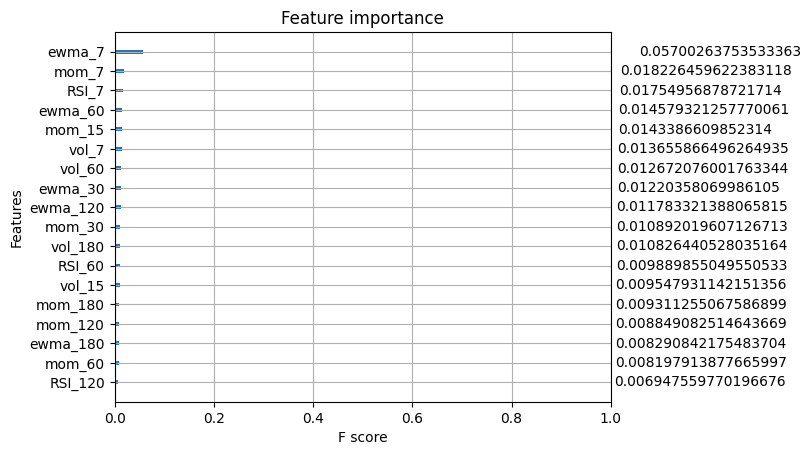

In [50]:
# params_r2 = {'n_estimators': 654, 
#           'learning_rate': 0.41560631208519555, 
#           'max_depth': 3, 
#           'min_child_weight': 1.9666756465978457, 
#           'subsample': 0.5485395239289113, 
#           'colsample_bytree': 0.6885282611378943, 
#           'gamma': 3.7589062962478, 
#           'reg_alpha': 0.004849800478451076, 
#           'reg_lambda': 1.582777002019766e-05, 
#           'tree_method': 'auto'}

params_r2 = {'n_estimators': 991, 'learning_rate': 0.015711695740729274, 'max_depth': 2, 'min_child_weight': 8.624798183270617, 'subsample': 0.8390072067198501, 'colsample_bytree': 0.7614058759408985, 'gamma': 0.0023576127846242144, 'reg_alpha': 8.885962719288432e-05, 'reg_lambda': 4.622211315736798e-05, 'tree_method': 'exact'}

model = xgb.XGBRegressor(**params_r2, random_state=42)
model.fit(X_train_reg, y_train_reg)
#importance = model.get_booster().get_score(importance_type='gain')

# Assuming 'model' is your trained XGBoost model

# Adjust the figure size
plt.figure(figsize=(12, 8))

# Plot feature importance
ax = xgb.plot_importance(model.get_booster(), importance_type='gain')

# Adjust x-axis range if necessary
ax.set_xlim(0, 1)  # Modify the range to fit your data (optional)

# Adjust label size for better readability
ax.tick_params(axis='both', labelsize=10)

# Display the plot
plt.show()

# xgb.plot_importance(model.get_booster(), importance_type='gain')
# plt.show()

In [44]:
# params_mse={'n_estimators': 905,
#             'learning_rate': 0.5690905084189695, 
#             'max_depth': 2, 
#             'min_child_weight': 1.925022951585389, 
#             'subsample': 0.7027423437070898, 
#             'colsample_bytree': 0.7128179776032951, 
#             'gamma': 6.944872367285347, 
#             'reg_alpha': 0.18383908297791254, 
#             'reg_lambda': 0.0035713122604259274, 
#             'tree_method': 'hist'}

params_mse ={'n_estimators': 270, 
             'learning_rate': 0.023887610039222115, 
             'max_depth': 4, 
             'min_child_weight': 2.024388714685194, 
             'subsample': 0.6429271022216754, 
             'colsample_bytree': 0.9560107882573772, 
             'gamma': 1.1324720548925758e-05, 
             'reg_alpha': 0.005553800489043667, 
             'reg_lambda': 0.004930587488387167, 
             'tree_method': 'hist'}

model = xgb.XGBRegressor(**params_mse, random_state=42)
model.fit(X_train_reg, y_train_reg)
importance = model.get_booster().get_score(importance_type='gain')
# xgb.plot_importance(model.get_booster(), importance_type='cover')
# plt.show()
print(importance)
# for some reason this doesnt work. dont know why haha

{'vol_7': 0.00960703194141388, 'RSI_7': 0.011528697796165943, 'mom_7': 0.012562400661408901, 'ewma_7': 0.03556119650602341, 'vol_15': 0.006217191461473703, 'RSI_15': 0.007373215164989233, 'mom_15': 0.009957121685147285, 'ewma_15': 0.010056025348603725, 'vol_30': 0.007010037079453468, 'RSI_30': 0.006623235065490007, 'mom_30': 0.008428875356912613, 'ewma_30': 0.007819181308150291, 'vol_60': 0.006729306653141975, 'RSI_60': 0.006415623240172863, 'mom_60': 0.0069651794619858265, 'ewma_60': 0.007596637587994337, 'vol_120': 0.006542076822370291, 'RSI_120': 0.006883599329739809, 'mom_120': 0.007004881277680397, 'ewma_120': 0.0086992671713233, 'vol_180': 0.005918880924582481, 'RSI_180': 0.00785832293331623, 'mom_180': 0.0064331404864788055, 'ewma_180': 0.008274939842522144}
